# Visualização arquivo DICOM 


In [3]:
# #Descomentar na primeira utilização do arquivo.
#%pip install pydicom numpy matplotlib scikit-image ipywidgets nibabel pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg gdcm
#
# #Ative widgets:
#%pip install ipywidgets
#import sys
#if 'google.colab' in sys.modules:
#    from google.colab import output
#    output.enable_custom_widget_manager()
#else:
# # JupyterLab clássico
#    import ipywidgets as widgets
#    widgets.Widget.widget_types

In [4]:
import os
from pathlib import Path
import numpy as np
import pydicom
from pydicom.filereader import dcmread
from pydicom.multival import MultiValue
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Dropdown
from typing import List, Tuple, Optional

In [5]:
def obter_tag(ds, name, default=None):
    """Lê uma tag DICOM com segurança e converte MultiValue para uma tupla, se necessário."""
    try:
        val = getattr(ds, name)
        if isinstance(val, MultiValue):
            return tuple(val)
        return val
    except Exception:
        return default

def to_numpy(ds: pydicom.dataset.FileDataset) -> np.ndarray:
    """Converte os dados de pixel do DICOM para uma lista NumPy em formato float32, 
    aplicando RescaleSlope e RescaleIntercept quando existem, e ajustando a 
    interpretação fotométrica."""
    arr = ds.pixel_array.astype(np.float32)
    slope = float(obter_tag(ds, 'RescaleSlope', 1.0) or 1.0)
    intercept = float(obter_tag(ds, 'RescaleIntercept', 0.0) or 0.0)
    arr = arr * slope + intercept
    # Corrige MONOCHROME1 (onde preto/branco são invertidos)
    photo = str(obter_tag(ds, 'PhotometricInterpretation', '') or '')
    if photo.upper() == 'MONOCHROME1':
        arr = arr.max() - arr
    return arr

def windowing(img: np.ndarray, center: Optional[float], width: Optional[float]) -> np.ndarray:
    """Aplica windowing; se center/width não existirem, normaliza para [0,1] pelo percentil 0.5-99.5."""
    if center is not None and width is not None and width > 0:
        low = center - width / 2.0
        high = center + width / 2.0
    else:
        # fallback robusto
        low, high = np.percentile(img, [0.5, 99.5])
        if high <= low:
            low, high = img.min(), img.max()
    img_w = np.clip(img, low, high)
    img_w = (img_w - low) / max(high - low, 1e-6)
    return img_w

def show_image(img01: np.ndarray, title: str = '', cmap: str = 'gray'):
    """Exibe a imagem usando Matplotlib"""
    plt.figure()
    plt.imshow(img01, cmap=cmap)
    plt.title(title)
    plt.eixo('off')
    plt.show()

## 1) Ler e visualizar um **arquivo DICOM** único
 Para obter um resultado defina o caminho do arquivo (`.dcm`) e rode.


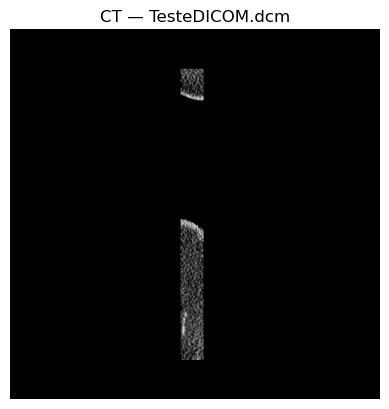

PatientID: C3L-00610
StudyDescription: CT ABDOMEN AND PELVIS
SeriesDescription: SAG 2X2 BODY
Modality: CT
Rows: 512
Columns: 512
PixelSpacing: ('0.734375', '0.734375')
SliceThickness: 2.000000
SpacingBetweenSlices: 
WindowCenter: 40
WindowWidth: 400
PhotometricInterpretation: MONOCHROME2


In [6]:
# --> Ajuste aqui o caminho do seu arquivo DICOM
dicom_path = Path('D:\Ana\Download\TesteDICOM.dcm')

if dicom_path.exists():
    ds = dcmread(dicom_path)
    img = to_numpy(ds)

    wc = obter_tag(ds, 'WindowCenter', None)
    ww = obter_tag(ds, 'WindowWidth', None)

    # WindowCenter/Width pode ser múltiplo, utilizará o primeiro se necessário [0]
    if isinstance(wc, (tuple, list)): wc = float(wc[0])
    if isinstance(ww, (tuple, list)): ww = float(ww[0])

    img_w = windowing(img, wc if wc is not None else None, ww if ww is not None else None)
    show_image(img_w, title=f'{obter_tag(ds, "Modality", "DICOM")} — {dicom_path.name}')

    # Metadados
    meta = {
        'PatientID': obter_tag(ds, 'PatientID', ''),
        'StudyDescription': obter_tag(ds, 'StudyDescription', ''),
        'SeriesDescription': obter_tag(ds, 'SeriesDescription', ''),
        'Modality': obter_tag(ds, 'Modality', ''),
        'Rows': obter_tag(ds, 'Rows', ''),
        'Columns': obter_tag(ds, 'Columns', ''),
        'PixelSpacing': obter_tag(ds, 'PixelSpacing', ''),
        'SliceThickness': obter_tag(ds, 'SliceThickness', ''),
        'SpacingBetweenSlices': obter_tag(ds, 'SpacingBetweenSlices', ''),
        'WindowCenter': wc,
        'WindowWidth': ww,
        'PhotometricInterpretation': obter_tag(ds, 'PhotometricInterpretation', ''),
    }
    for k, v in meta.items():
        print(f'{k}: {v}')
else:
    print('Defina um caminho válido em `dicom_path` antes de executar esta célula.')


## 2) Carrega uma **série DICOM** (pasta) e formar um volume 3D
Para obter um resultado satisfatório adicione o caminho da pasta contendo apenas a série desejada.


Volume shape (Z, Y, X): (189, 512, 512)
Voxel spacing (dz, dy, dx): (0.734375, 0.734375, 0.734375)
Modality: CT
Series: SAG 2X2 BODY
Study: CT ABDOMEN AND PELVIS


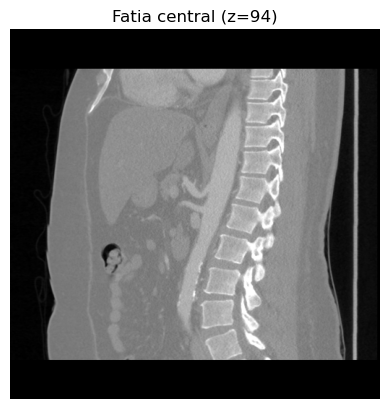

In [7]:
# >>> Ajuste aqui o caminho da pasta da série DICOM
series_dir = Path('D:\Ana\Download\seriedicom')

def is_dicom(path: Path) -> bool:
    """Verifica se um arquivo é um DICOM, checa a extensão ou o cabeçalho."""
    if not path.is_file():
        return False
    if path.suffix.lower() == '.dcm':
        return True
    try:
        with open(path, 'rb') as f:
            pre = f.read(132)
            return pre[-4:] == b'DICM'
    except Exception:
        return False

def serie_arquivos(dirpath: Path) -> Tuple[np.ndarray, dict]:
    """Lê uma pasta inteira de arquivos DICOM, os ordena e empilha para o volume 3D."""
    files = sorted([p for p in dirpath.iterdir() if is_dicom(p)])
    if not files:
        raise FileNotFoundError('Nenhum DICOM encontrado na pasta.')
    datasets = [dcmread(str(p)) for p in files]
    # Ordena
    def sort_key(ds):
        inst = obter_tag(ds, 'InstanceNumber', None)
        ipp = obter_tag(ds, 'ImagePositionPatient', None)  # (x,y,z)
        z = ipp[2] if (isinstance(ipp, (tuple, list)) and len(ipp) == 3) else None
        sl = obter_tag(ds, 'SliceLocation', None)
        return (
            float(inst) if inst is not None else float('inf'),
            float(z) if z is not None else float('inf'),
            float(sl) if sl is not None else float('inf'),
        )
    datasets.sort(key=sort_key)
    # Empilha
    imgs = [to_numpy(ds) for ds in datasets]
    vol = np.stack(imgs, eixo=0).astype(np.float32)  # (Z, Y, X)
    # Espaçamentos (voxel size)
    px = obter_tag(datasets[0], 'PixelSpacing', (1.0, 1.0))
    if isinstance(px, (list, tuple)) and len(px) >= 2:
        dy, dx = float(px[0]), float(px[1])
    else:
        dy, dx = 1.0, 1.0
    dz = float(obter_tag(datasets[0], 'SliceThickness', obter_tag(datasets[0], 'SpacingBetweenSlices', 1.0)) or 1.0)

    meta = {
        'shape': vol.shape,  # (Z, Y, X)
        'spacing': (dz, dy, dx),
        'modality': obter_tag(datasets[0], 'Modality', ''),
        'series_description': obter_tag(datasets[0], 'SeriesDescription', ''),
        'study_description': obter_tag(datasets[0], 'StudyDescription', ''),
    }
    return vol, meta

if series_dir.exists():
    try:
        volume, meta = serie_arquivos(series_dir)
        print('Volume shape (Z, Y, X):', meta['shape'])
        print('Voxel spacing (dz, dy, dx):', meta['spacing'])
        print('Modality:', meta['modality'])
        print('Series:', meta['series_description'])
        print('Study:', meta['study_description'])

        midz = volume.shape[0] // 2
        # window automático baseado em percentis se não houver tags
        img_w = (volume[midz] - np.percentile(volume[midz], 0.5)) / (np.percentile(volume[midz], 99.5) - np.percentile(volume[midz], 0.5) + 1e-6)
        img_w = np.clip(img_w, 0, 1)
        show_image(img_w, title=f'Fatia central (z={midz})')
    except Exception as e:
        print('Erro ao carregar a série:', e)
else:
    print('Defina um caminho válido em `series_dir` antes de executar esta célula.')

## 3) Visualizador interativo (slider)
Utilize o slider para navegar pelas fatias ao longo do eixo.


In [14]:
# Rode depois de ter `volume` carregado no bloco anterior
def slider(volume: np.ndarray, eixo: int = 0):
    """Cria uma interface interativa (com slider) para navegar pelas fatias de um volume 3D."""
    assert volume.ndim == 3, 'O volume deve ter 3 dimensões (Z, Y, X).'
    eixo = int(eixo)
    n = volume.shape[eixo]
    
    def view(idx: int, eixo_sel: int):
        if eixo_sel == 0:
            img = volume[idx, :, :]
        elif eixo_sel == 1:
            img = volume[:, idx, :]
        else:
            img = volume[:, :, idx]
        low, high = np.percentile(img, [0.5, 99.5])
        img01 = (np.clip(img, low, high) - low) / max(high - low, 1e-6)
        show_image(img01, title=f'Eixo {eixo_sel} — índice {idx}')
    interact(
        view,
        idx=IntSlider(min=0, max=max(0, n-1), step=1, value=n//2, description='Fatia'),
        eixo_sel=Dropdown(options=[( 'Z (0)',0 ),('Y (1)',1),('X (2)',2)], value=0, description='Eixo'),
    )

slider(volume, eixo=0)

interactive(children=(IntSlider(value=94, description='Fatia', max=188), Dropdown(description='Eixo', options=…

## 4) Histograma de intensidades
Utilizado para a análise da distribuição de valores de um array.

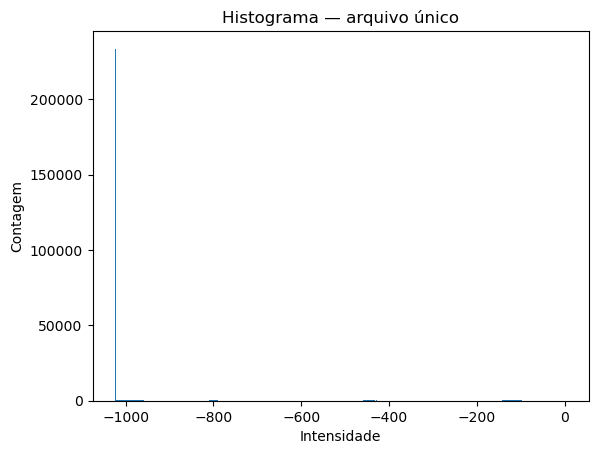

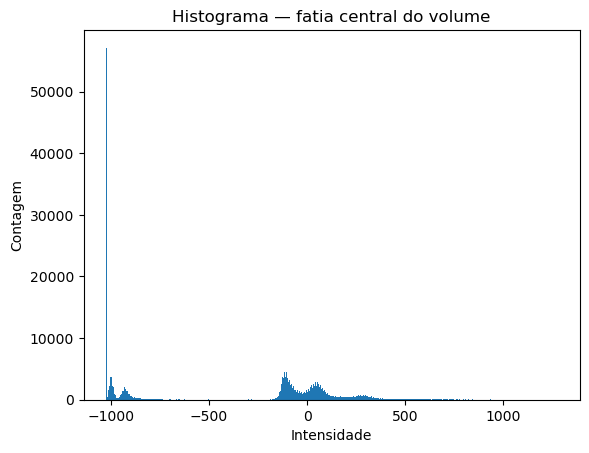

In [10]:
# Se `img` (fatia) ou `volume` estiverem definidos, você pode inspecionar o histograma:
def plot_histogram(data: np.ndarray, bins: int = 512, title: str = 'Histograma'):
    data = data[np.isfinite(data)]
    plt.figure()
    plt.hist(data.flatten(), bins=bins)
    plt.title(title)
    plt.xlabel('Intensidade')
    plt.ylabel('Contagem')
    plt.show()

plot_histogram(img, title='Histograma — arquivo único')
plot_histogram(volume[volume.shape[0]//2], title='Histograma — fatia central do volume')


## 5) Volune em **NIfTI**
Salva um volume 3D em um arquivo NIfTI (.nii.gz), útil para outros softwares de visualização ou IA.

In [12]:
# %pip install nibabel  # apenas se ainda não instalado

In [13]:
# import nibabel as nib

# def salvar_nifti(volume: np.ndarray, spacing: Tuple[float, float, float], out_path: Path):
#    dz, dy, dx = spacing
#    affine = np.array([[dx, 0,  0,  0],
#                       [0,  dy, 0,  0],
#                       [0,  0,  dz, 0],
#                       [0,  0,  0,  1]], dtype=float)
#    nii = nib.Nifti1Image(volume.astype(np.float32), affine)
#    nib.save(nii, str(out_path))
#    print('Salvo em:', out_path)

# Exemplo:
# out_file = Path('volume.nii.gz')
# salvar_nifti(volume, meta['spacing'], out_file)
